In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ffffffd
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        '''
        data - to be stored as value
        _children - previous values that operated to produce current Value
        _op - operation on previous two values that resulted in this Value
        _backward - chains gradient of output with input, defined for _op nodes
                - None for leaf (non _op) nodes 
        '''
        
        self.data = data
        self._prev = set(_children)  # Values which resulted in current Value
        self.grad = 0.0  # maintains the derivative of this Value wrt Loss 
        self._backward = lambda: None
        self._op = _op
        self.label = label  #

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        # take out's grad and propagate it to self and other's grads
        # called after forward prop, i.e. when + already executed and backprop will have out.grad already
        def _backward():
            # dL/dself = dL/dout * dout/dself, below in reversed order
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        # at Forward pass
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        # called at backward pass 
        def _backward():
            # dL/self = dL/dout * dout/dself
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out
    
    def __rmul__(self, other): #other * self (other is not Value)
        return self * other  # here self(Value) object's __mul__ is called.    

    def __pow__(self, other): 
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data ** other, _children=(self,), _op=f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad  # self.data is int or float, ** takes precedence over *
        out._backward = _backward
        return out

    
    def __truediv__(self, other): # self / other
        return self * (other**-1)
    
    def __neg__(self): #-self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        #t = np.tanh(x)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            # self -> tanh -> out
            # dL/dself = dL/dout * dout/dself
            # we'll have dL/dout or out.grad when this func is called due to backprop
            self.grad += out.grad * (1 - (t ** 2))
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), _children=(self,), _op='exp')
        
        def _backward():
            self.grad += out.data * out.grad  # d.grad is derivative propagated until out, out.data is obtained at forward prop
            
        out._backward = _backward
        return out
        
    def backward(self):
            # build topo graph starting at self
            topo = []
            visited = set()
            
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                        build_topo(child)
                    topo.append(v)
            
            build_topo(self)                
            self.grad = 1.0
            for node in reversed(topo):
                node._backward()
    

In [3]:
a = Value(2.0, label='a')
a

Value(data=2.0)

In [4]:
b = Value(-3.0, label='b')

In [5]:
a + b

Value(data=-1.0)

In [6]:
a.__add__(b)

Value(data=-1.0)

In [110]:
a*b

Value(data=40.107584470096704)

In [111]:
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-100.21516894019341)

In [112]:
(a.__mul__(b)).__add__(c)

Value(data=50.107584470096704)

In [113]:
d._prev # Values that resulted in d (a*b and c)

{Value(data=10.0), Value(data=40.107584470096704)}

In [114]:
d._op # operation on d._prev that resulted in d

'+'

In [115]:
def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

nodes, edges = trace(d)
print(nodes, edges)

{Value(data=-6.0), Value(data=0.8813735870195432), Value(data=50.107584470096704), Value(data=10.0), Value(data=0.0), Value(data=5.828427124746192), Value(data=-6.0), Value(data=40.107584470096704), Value(data=1.7627471740390863), Value(data=6.881373587019543), Value(data=0.0), Value(data=2), Value(data=2.0), Value(data=-3.0), Value(data=1.0)} {(Value(data=2.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=1.0), Value(data=0.0)), (Value(data=40.107584470096704), Value(data=50.107584470096704)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=1.7627471740390863), Value(data=5.828427124746192)), (Value(data=5.828427124746192), Value(data=40.107584470096704)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=10.0), Value(data=50.107584470096704)), (Value(data=0.0), Value(data=0.0)), (Value(data=0.8813735870195432), Value(data=1.7627471740390863)), (Value(data=2), Value(data=1.76274717

In [116]:
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
    
lol()

-3.9999999999995595


In [117]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

'+' node doesn't know about rest of the graph, all it knows is that it took c and e and result in d. so it only knows the derivative of d wrt c and e i.e. local derivative. local derivative of plus node is 1.0 wrt its operands in graph (operands are standalone values, scalers). So plus node literally routes (lets pass) the gradients backwards when using chain rule. (whatever the derivative of result variable wrt L is same of derivative of operands (here childrens of + node) wrt L due to chain rule.)

In [118]:
c.grad = -2.0
e.grad = -2.0

a.grad = -2 * -3
b.grad = -2 * 2.0

In [119]:
a.grad, b.grad

(6, -4.0)

We change a, b, c, f in drection of their gradients by little, which results in L going up.

In [120]:
a.data += 0.01 * a.grad # Increased in direction of gradient by small amount controlled by step_size 0.01
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d*f
L

Value(data=-98.51926240864292)

This way we can influence the final output
bias b is like trigger of happyness to the neuron, it can make neuron more or less happy regardless of the input. (think biologizally.)

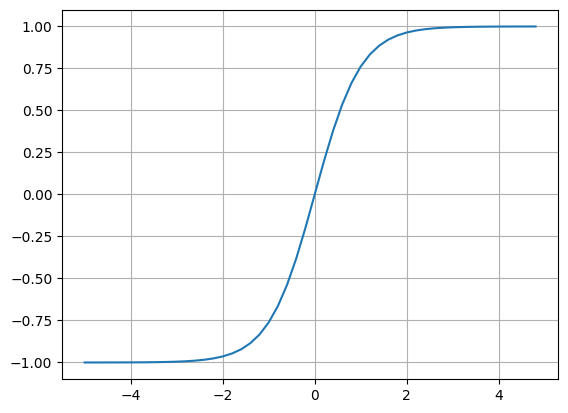

In [121]:
# Visualize tanh
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

- Very positive caps to 1, very negative caps to -1
- Weights are like synapses to neuron.
- You can define arbitrary function as op without being atomic given that you know the local derivative of that function.
  - eg. tanh implmented using np.exp function without explicitly defining our own exp

derivative of tanh(x) = 1 - tanh^(x)**2
- if o = tanh(x) then do/dx = 1 - o**2 : local derivative of tanh

- '+' is distributor of gradient from right to left
- local derivative of * is the other term

### Using _backward to backpropagate

In [122]:
# Forward pass
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

In [123]:
# backward pass 

# base case, by default this is set to 0
L.grad = 1.0

In [124]:
L._backward()

In [125]:
d.grad, f.grad

(-2.0, 4.0)

In [126]:
# f is just a scaler value no need to backprop it
f._backward() # Nothing happens here, None is returned
d._backward()  

In [127]:
e.grad, c.grad

(-2.0, -2.0)

In [128]:
a.grad, b.grad

(0.0, 0.0)

In [129]:
e._backward()

In [130]:
a.grad, b.grad

(6.0, -4.0)

Thus we have implemented backprop using _backward() of each op node.  
We also want to automate that:  
We want to call _backward on node when all its previous backprop is done.  
This order of graph can be achieved using what is called *'topological sort'*.  
It's laying out of graph such that all the edges goes from only left to right.  
Below we implement topological sort:

In [131]:
# Build topologicl graph
topo = []
visited = set() # Maintain vissited nodes

# Starts at root, goes throught all its childern, lay them out from left to right
# if child not visited, marks it as visited
# Adds itself after visiting all its childrens
# L is going to be added in topo after all of the cildrens have been procesed
# this function guarantees that your in list once all childrens are in list
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(L)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=10.0),
 Value(data=4.0),
 Value(data=-2.0),
 Value(data=-8.0)]

This has ordered our Value objects from right to left.  
-8.0 is L. All its childrens are in list then it's added.

In [132]:
# Reset gradients 

# Forward pass
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

In [133]:
for node in [a, b, c, e, d, f, L]:
    print(node.grad)

0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [134]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(L)

# backprop 

# base case 
L.grad = 1.0

# go left to right
for node in reversed(topo):
    node._backward()

for node in [a, b, c, e, d, f, L]:
    print(node.grad)

6.0
-4.0
-2.0
-2.0
-2.0
4.0
1.0


Finally we hide this functionality in Value class above.

In [135]:
# Reset gradients 

# Forward pass
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

for node in [a, b, c, e, d, f, L]:
    print(node.grad)

0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [136]:
L.backward()

In [137]:
for node in [a, b, c, e, d, f, L]:
    print(node.grad)

6.0
-4.0
-2.0
-2.0
-2.0
4.0
1.0


This was backprop for one neuron. **But there is a bug**:

In [138]:
a = Value(data=3.0, label='a')
b = a + a; b.label='b'
b.backward()
a.grad, b.grad

(2.0, 1.0)

This gradient is not correct.  
By calculus a.grad should be 2.0  
a used twice in expression, but in out __add__ we treat left a as 'self' object while right a which is same as left as 'other' object.  
In its _backward(), self.grad is set to 1.0, but other.grad is also set to 1.0. Here we're overwriting grad of a.  
i.e. a.grad = 1.0, a.grad = 1.0 this is happening.
In this case, self and other are suposed to be exact same object.

This issue will arise anytime we use any variable more than once. Consider following:

In [139]:
# a, b -> e = a + b -> f = d * e  
#      -> d = a * b ->
a = Value(-2)
b = Value(3)

d = a * b
e = a + b
f = d * e

f.backward()
a.grad, b.grad, d.grad, e.grad, f.grad

(-3.0, -8.0, 1.0, -6.0, 1.0)

This are not correct.  
When going backwards, the + operater first correctly propagates gradient to a, b.  
But then after d, * operator propagates other gradients to a, b, overwriting on previous ones.  
**The solution is multivariable chain rule.**  
The solution is we accumulate or add these gradients.  
i.e. in Value class, we set in _backward: self.grad += local_grad * out.grad.  
This way we add to previosuly stored grad of variable. Initially grad set to 0 so this is ok.  
So we start grad at 0 and any contribution that flows backwards will simply add.

We'll now define tanh in terms of x.   
We had define it in terms of math.exp() function and we wrote it's derivative based on analytical solution (like on paper).  
We could implement exp() function ourself so that derivative of tanh will be chained with this function instead of explicitly stating derivative of tanh.  
Doing this way will allow us to implement few more operations.

Right now we cant add an int to Value object. Lets modify definition of Value so that if int passed as 'other' in __add__ it'll be converted to Value object first. Make sure int comes after + operand.

In [140]:
a = Value(2) 
a + 1

Value(data=3)

Same goes for *

In [141]:
a * 2

Value(data=4)

but this will raise error as python doesn't know how to do `2 * a`.  
This is same as `2.__mul__(a)`. 2 is an `int` object while `a` is an `Value` object.  
a is passed as other to the `int` class's `__mul__` method. And it's not defined there what to do if other is `Value` object.  
Instead you can define `__rmul__()` in `Value`. This is kind of fallback.  
If python can't do `2*a`, it'll check *if by any chance `a` knows how to multiply `2`. And that will be called into `__rmul__()`.
If python can't do `2*a`, it'll check if there's an `__rmul__` in `Value` and is called if present.  
Here order of `2*a` are swapped, `__rmul__` passes a as self and 2 as other.

In [142]:
2 * a

Value(data=4)

stack overflow:
When Python attempts to multiply two objects, it first tries to call the left object's __mul__() method. If the left object doesn't have a __mul__() method (or the method returns NotImplemented, indicating it doesn't work with the right operand in question), then Python wants to know if the right object can do the multiplication. If the right operand is the same type as the left, Python knows it can't, because if the left object can't do it, another object of the same type certainly can't either.

If the two objects are different types, though, Python figures it's worth a shot. However, it needs some way to tell the right object that it is the right object in the operation, in case the operation is not commutative. (Multiplication is, of course, but not all operators are, and in any case * is not always used for multiplication!) So it calls __rmul__() instead of __mul__().

Now we implment exp() operation of Value using math.exp().  
We do this so that we have exp() operation in out backprop.

In [143]:
a = Value(2)
a.exp()

Value(data=7.38905609893065)

Now we implement division. But we define it bu shuffling some operations as follows:  
a = Value(2), b = Value(3)  
a / b = a * (1 / b) = a * (b**-1)  

Thus we want to implement an operation `x**k` for some `int` or `float` `k` and we would like to differentitate it.  
And as a special case `k=-1` will be a division.

define division using special method `__truediv__(self, other):` which will be called when `self / other` is seen.

In [144]:
a = Value(2)
b = Value(4)
a / b

Value(data=0.5)

Now overlaod - also using `__sub__`.  
define subtraction as addition of negation:
a - b = a + (-b)

and define negation using `__neg__(self)` which returns `self * -1` where we already have implemented `*`.

In [145]:
a = Value(2)
b = Value(4)
a - b

Value(data=-2)

Now remimplemnt forward pass using explicit formula for tanh

In [146]:
# Reset gradients 

# Forward pass
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

c = x1 * w1; c.label='c' 
d = x2 * w2; d.label='d'
e = c + d; d.label='d'
n = e + b; n.label='n'

#----
o = n.tanh()
#----
o.label='o'
o.backward()
o.grad, n.grad, e.grad, d.grad, c.grad, b.grad, w2.grad, w1.grad, x2.grad, x1.grad

#draw_dot(o)

(1.0,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.0,
 0.9999999999999998,
 0.4999999999999999,
 -1.4999999999999996)

Now using explicit formula

In [147]:
# Reset gradients 

# Forward pass
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

c = x1 * w1; c.label='c' 
d = x2 * w2; d.label='d'
e = c + d; d.label='d'
n = e + b; n.label='n'

#----
a = (2*n).exp()
o = (a - 1) / (a + 1)
#----
o.label='o'
o.backward()
o.grad, n.grad, e.grad, d.grad, c.grad, b.grad, w2.grad, w1.grad, x2.grad, x1.grad

#draw_dot(o)

(1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 1.0, 0.5, -1.5)

The level at which you imppplement operations is up to you, you can implment them upto level of + and * , or at level of tanh which is composite operations.  
All that matters is that we have some input some output which is function of inputs in some way, as long as you can do forward pass and backward pass of that little operation, it doesnt matter what that operation is and how compposite it is.  
If you can write the local grads, chanin the grads and continue backprop. So design of what those functios are its completely upto you.

Now do it in pytorch

In [148]:
import pytorch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
x1 = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('___')
print('x2', x2.grad.item())
print('w2', x2.grad.item())
print('x1', x2.grad.item())
print('w1', x2.grad.item())

ModuleNotFoundError: No module named 'pytorch'

Tensors are n dimensional arrays of scalars.  
See its shape using `.shape` attribute  
We're casting Tensors to be double as python by default used double for floating point numbers.  
By dfault data type of Tensors will be float32. We cast here to duble i.e. float64 just as in python.

Because above are leaf nodes, by defauly pytorch assumes that do not require gradients, So we explicitly tell pytorch that all these nodes requires gradient using `requires_graident = True`. By dafut these are `False` for leaf nodes like inputs of the network, for efficiency reasons in most common cases.  

Just like `Value` obejct, `Tensor` object has `.data` and `.grad` attribute. Their `.item()` method takes single Tenosr of one element and returns just that element, stripping out the tensor.

Above, `o` is the `tensor` and `.item()` will extract numerical value stored in it. (here 0.707...).
tensor also has `backward()` method just as we implemented. Every tensor also has `.grad` i.e. gradients. We can pop oout the number using `.grad.items()` method.

`o.item()` and `o.data.item()` will produce the same result in pytorch.

We can now start bulding neural nets. We define a neuron in similar way of how pytorch designs its neurons in its nn module.

In [149]:
import random

In [150]:
# nnnnnn
class Neuron:
    def __init__(self, nin):
        '''
        nin - number of inputs to this neuron '''
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # Create weights for every one of the inputs nin.
        self.b = Value(random.uniform(-1, 1))  # Controls the overall 'trigger happiness' of this neuron

    def __call__(self, x): 
        # returns dot product of x with w's
        
        act = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b) 
        out = act.tanh() # Non linearity
        
        return out

    # convenient function to return list of current neuron's all parameters
    def parameters(self):
        return self.w + [self.b]  # list of all w's and b.   self.w is a list

pytorch has similar parametrs() that returns parameters of tensors. here we do it for scalars.

In [151]:
x = [2.0, 3.0]
n = Neuron(2)  # for 2 dimensional
n(x)

# You get different result everytime you run this beacuse of randomness in w's.

Value(data=0.7487510234949275)

`zip(self.w, x)` takes two iterators and create a new iterator that iterates over tuples of corresponding entries, such that  
```python
print(list(zip(self.w, x)))
>>>
[(Value(data=-0.7495835769305297), 2), (Value(data=0.5123887578748552), 3)]
```
First value in tuple is w and second is x repectively.

`def __call__(self, x)` This is called when Neuron object is called as in `n(x)` where `n` is a neuron.

```python
act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b 
```
This works because `sum` sums up addition of all pairs wi, xi.  
since wi is `Value` and xi is `float` or `int`, in `sum()`, `__add__` of `int` or `float` class is called.  
But that class doesn't know how to add `Value` object to it.  
So python looks if `Value` has defined `__radd__()` which means `Value` obejct is at right of `+` operand.  
We do have define `__radd__` for `Value` class which simple returns `self + other` where other is now an `int`.  
This calls `__add__` of `Value` passing `Value` as self and `int` as other.  

*`sum` takes a second optional argument called `start` which is value over which all elements are added*.  
So for efficiency, we specif `start=self.b` so that all wi*xi will be added on top of that and we don;t have to separately add `self.b`.

Next we define a layer of neurons.  
A layer of neurons is a set of neurons evaluated independently.

In [152]:

class Layer:
    def __init__(self, nin, nout):
        '''
        nin : dimension of input (total inputs)
        nout : total number of neurons in current layer (dimension of output)
        '''
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        '''
        x - input to layer
        '''
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs  # for convinience get single neuron if #ouput is 1. 
                                                    # return lists outs if #output neurons > 1

    # Collect all the parameters of a layer
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] # single list comprehensions (nested for's)
    

Layer contains list of neurons. Number of neurons we have is input argument `nout`.  
When called we reutrn `out` which is just neurons in list evaluated (called) independently.

In [153]:
x = [2.0, 3.0]
n = Layer(nin=2, nout=3)
n(x)

# nin = 2 because x has 2 elements. Here we get 3 neurons evaluaion as output.

[Value(data=-0.26919915961602253),
 Value(data=-0.8565253635841719),
 Value(data=0.46176000197934997)]

`nin` is the #elements coming from input so as to initialzie #weights in each neuron  
`nout` is the #neurons in current layer, each will evaluate one value and whole output will be `nout` dimesnional.  

Now let's define MultiLayerPerceptron (MLP):  
MLP is a layers feed each other sequentially.

In [189]:
class MLP:
    
    def __init__(self, nin, nouts):
        # size of neurons in each layer (input + other layers)
        sz = [nin] + nouts
        # Iterate over sizes and create Layer size for them
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

- `nin`Number of inputs as before  
- `nouts` list of all the `nout`, this list defines sizes of all the layers that we want in out MLP.
- `__call__` calls all layers sequentially, feeding input to first layer, then it's ouput, to next layer and so on until we get final layer's output.  

Note that for each layer, it's previous layer's output is its input.

Lets implement MLP as :  
3 neurons input -> 4 neurons layer -> 4 neurons layer -> 1 neuron output layer:

In [190]:
# Input (should have 3 elements correcsponding to 3 neurons)
x = [2.0, 3.0, -1.0]

# MLP(#inputs, [size of each layer])
n = MLP(3, [4, 4, 1])

# run MLP
n(x)

Value(data=0.8405096646132303)

In [191]:
# All weights and biases inside entire nn MLP
n.parameters()

[Value(data=-0.3393122214461519),
 Value(data=-0.22736223241330555),
 Value(data=-0.4084047043402126),
 Value(data=0.18085217644195928),
 Value(data=0.06055873937857381),
 Value(data=-0.9209549406130084),
 Value(data=0.8723189539704386),
 Value(data=0.6789690271591673),
 Value(data=-0.5393785584853745),
 Value(data=0.6772880145288525),
 Value(data=-0.6056728716358728),
 Value(data=-0.21708314882118662),
 Value(data=0.7589726120191778),
 Value(data=-0.6634089749232364),
 Value(data=-0.7589303180769256),
 Value(data=0.010447964598380377),
 Value(data=-0.997636507177941),
 Value(data=-0.3337416040386165),
 Value(data=0.6608864153425518),
 Value(data=0.9824229077176931),
 Value(data=-0.6044930512239601),
 Value(data=-0.8122677648792194),
 Value(data=0.9145174517857348),
 Value(data=0.7975629294705224),
 Value(data=0.06208350970819354),
 Value(data=0.46099264797205985),
 Value(data=0.33802366820205143),
 Value(data=-0.4090335254169264),
 Value(data=-0.7542023854403044),
 Value(data=0.634323

In [192]:
# Total parameters in MLP
len(n.parameters())

41

In [193]:
# draw_dot(n(x)) tot drwae whole MLP

With micrograd we can backpropagate through all network to getting grads of w's and b's

In [209]:
# Example dataset (similar to binary classifier)

# 4 examples of 3 elements each
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

# Let's see what nn curently thinks of this example :
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9999999999996664),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=0.9999999999996664)]

these are the outpuuts of the nn on those 4 examples xs.  
the performance of nn is not good as predictions does not looks like targets.
It should really resemble target labels ys. 
We update weights w's and b's so that nn make better predictions of desired targets.  

Trick is to define a single number that meaures total performance of your nn, we call this single number the loss.

The loss will be high when nn's predictions are far from target and we want to minimize the loss.
We use mean squared error loss as follows:

In [210]:
# ygt for y ground truths
# Individual loss components for each exmaple
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=1.1130365149481824e-25),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=1.1130365149481824e-25)]

we take predictions and ground truths, pair them, subtract them and square them.

As we can see, those predictions that are near to ground truth have small loss and those which are far have high loss. 

Final loss will be sum of all these numbers:

In [211]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=2.2260730298963647e-25)

We want this loss to be near zero so predictions are very near to target

In [212]:
loss.backward()

With above line, backprop is happened across MLP and w's and b's now have grads:

In [213]:
# w of first layer first neuron
n.layers[0].neurons[0].w[0]

Value(data=14.46521934873515)

In [214]:
# gradient of that w because of backprop
n.layers[0].neurons[0].w[0].grad

-7.510646128207027

Since derivative is positive, the influence of this w in positive on loss, this w increases, loss increases. We have this info for all neurons and all their parameters.

In [215]:
# see above neurons data
n.layers[0].neurons[0].w[0].data

14.46521934873515

In [216]:
# draw_dot(loss)

grads of input data are not usable as input data is fixed and it is a given in a problem. We don't change it. 

In [217]:
# Tiny update to parameters based on grad info

for p in n.parameters():
    p.data += -(0.01 * p.grad)

if grad is +ve, increasing w in dir of its grad will increase w as well as the loss.
if grad is -ve, going in direction of grad will decrease the w, but if w is decreases, as grad is -ve, loss will increased.  
Se want to go in opoosite direction of gradient to minimize the loss.

In [218]:
n.layers[0].neurons[0].w[0].data

14.54032581001722

In [221]:
# Data increased by bit. as grad was -ve, increasing w makes loss go down.

In [242]:
# Input (should have 3 elements correcsponding to 3 neurons)
x = [2.0, 3.0, -1.0]

# MLP(#inputs, [size of each layer])
n = MLP(3, [4, 4, 1])

# run MLP
n(x)

# Example dataset (similar to binary classifier)

# 4 examples of 3 elements each
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

# Let's see what nn curently thinks of this example :
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.3417073902479911),
 Value(data=-0.460391035409648),
 Value(data=-0.4522643172012172),
 Value(data=-0.5680275655601227)]

In [243]:
# Iterate the process
for k in range(20):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # Compute loss
    loss.backward()

    # Update parametrs
    for p in n.parameters():
        p.data += -(0.05 * p.grad)

    print(k, loss.data)

0 4.8500813802798
1 3.5941195009469324
2 3.817806766049877
3 2.795212509035672
4 1.1524800436715144
5 0.3262226830963592
6 0.06724724110795116
7 0.027649831288717713
8 0.01621148877732779
9 0.010581451068870009
10 0.0070159886942897445
11 0.004596720007401912
12 0.002947258452250125
13 0.0018440355781614234
14 0.0011277134468607377
15 0.0006771579026596502
16 0.0004016334970402597
17 0.00023673415593389966
18 0.00013943447461138063
19 8.244883660908718e-05


loss decreased!

In [244]:
ypred

[Value(data=0.9999987606950086),
 Value(data=-0.9909203093780423),
 Value(data=-0.9999105423453185),
 Value(data=0.9999928858758135)]

y pred is closer to targets now!

loss is wobbly structure, big step can overstep local minima and end up at different structure that's completely different, that could destbilize training or even blow the loss.

In [245]:
n.parameters()

[Value(data=-1.781999053633227),
 Value(data=0.35894405752487507),
 Value(data=4.351049063077288),
 Value(data=0.6329353704555232),
 Value(data=-1.318921626802422),
 Value(data=-3.102221064929652),
 Value(data=2.3311720233596844),
 Value(data=-0.3662489922049612),
 Value(data=-1.6184070048787178),
 Value(data=3.9948143471804465),
 Value(data=-1.132793938720549),
 Value(data=0.14766934387853325),
 Value(data=-5.225771888143727),
 Value(data=3.17964794338328),
 Value(data=-2.8308929892066614),
 Value(data=-1.8815790331824096),
 Value(data=0.15843614181333485),
 Value(data=-0.4216544930408924),
 Value(data=0.8796434031442569),
 Value(data=-0.3633558669557103),
 Value(data=-0.09449208562944893),
 Value(data=-0.3432370028732889),
 Value(data=-0.7367068698307493),
 Value(data=0.9532552835171642),
 Value(data=1.1298688899183704),
 Value(data=-0.9687974139424894),
 Value(data=1.5513788246826046),
 Value(data=0.9417953511488502),
 Value(data=0.18649717509860128),
 Value(data=-0.7121643256320136

this is the settngs of nn that cause predictions of it to be very close to targets.

THERE IS A BUG IN OUT CODE: 
WE DIDN:T ZEORED OUT GRADS AFETR AN ITERATION...  
At each iteration we calculate grad and weights accordingly,  
at next iteration, we calculate fresh gradients but add it to previous gradient.  
Remember in our code we've done `+=` to every grads, so when we do `backward()`, **new gradient is added to previous gradient** which is not what we want.   
We want to update w based on gradient of its current position.  
**So we zero out gradients after each iteration**.  
This is `zero_grad()` in pytorch.  

Code with bug worked above because this is very simple problem, it's very easy even for buggy nn to fit this data. Here, grads got accumulated over every pass which gave us massive step size, convergin fast to solution.

In [257]:
# Input (should have 3 elements correcsponding to 3 neurons)
x = [2.0, 3.0, -1.0]

# MLP(#inputs, [size of each layer])
n = MLP(3, [4, 4, 1])

# run MLP
n(x)

# Example dataset (similar to binary classifier)

# 4 examples of 3 elements each
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

# Let's see what nn curently thinks of this example :
ypred = [n(x) for x in xs]

# Iterate the process
for k in range(20):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # Zero out all gradients
    for p in n.parameters():
        p.grad = 0.0
        
    # Compute loss
    loss.backward()

    # Update parametrs
    for p in n.parameters():
        p.data += -(0.05 * p.grad)

    print(k, loss.data)

0 6.682736882818457
1 3.940326984826172
2 3.6473064326456965
3 3.208315027095084
4 2.700999165961764
5 2.538611686160313
6 2.824549822229459
7 1.5978148961850824
8 0.5704586084526988
9 0.2532501073385463
10 0.21453204015620458
11 0.18529879944121425
12 0.16246184683287168
13 0.1441982405338574
14 0.1293090276344174
15 0.11697186999988697
16 0.10660566560822657
17 0.09778944669333116
18 0.09021161211764978
19 0.08363710623857798


Here we have converged slowly 

In [258]:
ypred

[Value(data=0.8787941686520615),
 Value(data=-0.8463578520233822),
 Value(data=-0.8615539550239035),
 Value(data=0.8382191739375744)]

nn can sometiems be tricky, you may have lots of bugs in your code but your network might still work. But if problem was very complex then this bug wouldn't have let us optimize the weights.

Above iteration of the process is wht we call **gradient descent**.  
The update to w's is what is called **stoachastic gradient descent update** where we update w's on evry example.  
People use slighlt different updates.  
loss can be different such as  cross-entropy loss.

Lets match module API of pytorch

In [261]:
class Module:

    def zero_grad(self):
        for p in self.parameters:
            p.grad = 0

    def parameters(self):
        return []

This will be the parent class of all classes we defined above.  
`nn.Module` in pytorch also has `zero_grad()` which we refactored out above.

Visit repo to see full code.

To test, use pytorch and compare your forward and backward pass to pytorch's results.

If we have lots of data, we pick subset of it called the batch, only process that bacth, make forward, backward and update pass on it

You can add any function to pytorch defined as class which should have forward pass and backward pass implemented. This way you can add your own lego block to castel of blocks that pytorch already has.